In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from scipy.stats import pearsonr
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.layers import LeakyReLU  # this is already covered by import
import random
import seaborn as sns
import sklearn
from tensorflow.keras import regularizers
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots


import pathlib
import shutil
import tempfile

from tensorflow.python.ops.gen_sparse_ops import add_many_sparse_to_tensors_map

In [2]:
def plot_loss(history):
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.ylim([0, 1.5])
    plt.title("Training and validation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Error [MAE]")
    plt.legend()
    plt.grid(True)
    plt.show()

    
def get_callbacks(name):
    return [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
    ]

"""
def df_to_dataset(dataframe_X, dataframe_y, shuffle=True, batch_size=BATCH_SIZE):
    dataframe = dataframe_X.copy()
    labels = dataframe_y
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds
"""
# deal with batching


'\ndef df_to_dataset(dataframe_X, dataframe_y, shuffle=True, batch_size=BATCH_SIZE):\n    dataframe = dataframe_X.copy()\n    labels = dataframe_y\n    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))\n    if shuffle:\n        ds = ds.shuffle(buffer_size=len(dataframe))\n    ds = ds.batch(batch_size)\n    ds = ds.prefetch(batch_size)\n    return ds\n'

In [3]:
pulse_data = pd.read_csv("../JET_EFIT_magnetic/sampled_data.csv")
pulse_data = pulse_data.dropna(axis=0)

y = pulse_data["FAXS"]
X = pulse_data.drop(["FAXS", "FBND", "Time"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=24
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=24
)


In [4]:

N_VALIDATION = int(len(X_val))
N_TRAIN = int(len(X_train))
BUFFER_SIZE = N_TRAIN
BATCH_SIZE = 50 # can crank this up
STEPS_PER_EPOCH = N_TRAIN//BATCH_SIZE



lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  0.001,
  decay_steps=STEPS_PER_EPOCH*1000,
  decay_rate=1,
  staircase=False)

def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

def compile_and_fit(model, name, optimizer=None, max_epochs=100):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(optimizer=optimizer,
                  loss='mean_absolute_error',
                 metrics='mean_absolute_error')

    model.summary()

    history = model.fit(
    X_train, y_train,
    steps_per_epoch = STEPS_PER_EPOCH,
    epochs=max_epochs,
    validation_data=(X_val, y_val),
    callbacks=get_callbacks(name),
    verbose=0)
    return history

In [5]:
"""
train_dataset = df_to_dataset(X_train, y_train, batch_size=BATCH_SIZE)
val_dataset = df_to_dataset(X_val, y_val, shuffle=False, batch_size=BATCH_SIZE)
test_dataset = df_to_dataset(X_test, y_test, shuffle=False, batch_size=BATCH_SIZE_SIZE)
"""
print('suppress output')

suppress output


In [6]:
normalizer = preprocessing.Normalization(axis=-1)
normalizer.adapt(np.array(X_train))
print(normalizer.mean.numpy())

# figure out memory efficient read in

[-2.5093343e-02 -4.9615569e-02 -4.6424255e-02 -2.4259649e-02
  6.9255829e-03 -4.5868944e-02  2.0864043e-02 -8.1199585e-03
 -7.3375169e-04 -2.8859854e-02  8.3007645e-03 -4.3399323e-02
  7.4391742e-03 -1.9918691e-02 -5.0057663e-04 -6.3997917e-02
 -1.6106095e-02  1.7231643e-02 -4.4246729e-02 -8.1350822e-03
  2.3486076e-02 -6.7413069e-04 -1.7184081e-02 -2.4307076e-02
 -3.5079548e-04 -5.6020926e-05 -1.2678855e-02 -5.4118615e-02
 -2.2734459e-02  1.4446205e-03 -1.2250117e-02 -3.2669835e-02
 -1.2740844e-03 -1.6417623e-02 -2.3757488e-02]


### Tiny model

In [7]:
tiny_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
size_histories = {}
size_histories['Tiny'] = compile_and_fit(tiny_model, 'sizes/Tiny')


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 35)                71        
_________________________________________________________________
dense (Dense)                (None, 16)                576       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 664
Trainable params: 593
Non-trainable params: 71
_________________________________________________________________


### Small model

In [8]:
small_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(16, activation='elu'),
    layers.Dense(16, activation='elu'),
    layers.Dense(1)
])
size_histories['Small'] = compile_and_fit(small_model, 'sizes/Small')


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 35)                71        
_________________________________________________________________
dense_2 (Dense)              (None, 16)                576       
_________________________________________________________________
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 17        
Total params: 936
Trainable params: 865
Non-trainable params: 71
_________________________________________________________________


### Medium model


In [9]:
medium_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(64, activation='elu'),
    layers.Dense(1)
])

size_histories['Medium']  = compile_and_fit(medium_model, "sizes/Medium")


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 35)                71        
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2304      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 10,760
Trainable params: 10,689
Non-trainable params: 71
_________________________________________________________________


### Too large model

In [10]:
large_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(512, activation='elu'),
    layers.Dense(1)
])

size_histories['large'] = compile_and_fit(large_model, "sizes/large")


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 35)                71        
_________________________________________________________________
dense_9 (Dense)              (None, 512)               18432     
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_12 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 513       
Total params: 806,984
Trainable params: 806,913
Non-trainable params: 71
_______________________________________________

(0.4, 1.5)

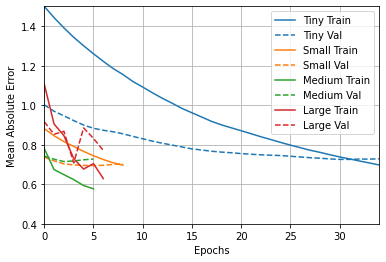

In [11]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'mean_absolute_error')
plotter.plot(size_histories)
plt.ylim([0.4, 1.5])


Text(0.5, 0, 'Epochs [Log Scale]')

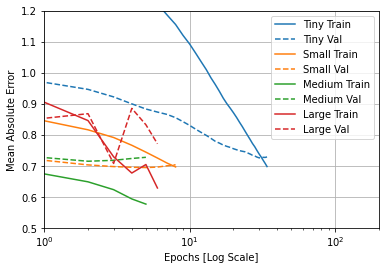

In [12]:
plotter.plot(size_histories)
a = plt.xscale('log')
#plt.xlim([1, max(plt.xlim())])
plt.xlim([1, 200])
plt.legend(loc="upper right")
plt.ylim([0.5, 1.2])
plt.xlabel("Epochs [Log Scale]")


## Regularisation

In [13]:
regularizer_histories = {}
regularizer_histories['Small'] = size_histories['Small']


In [14]:
l2_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(1)
])

regularizer_histories['Largel2'] = compile_and_fit(l2_model, "regularizers/Largel2")


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 35)                71        
_________________________________________________________________
dense_14 (Dense)             (None, 512)               18432     
_________________________________________________________________
dense_15 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_16 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_17 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 513       
Total params: 806,984
Trainable params: 806,913
Non-trainable params: 71
_______________________________________________

In [15]:
dropout_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['dropout'] = compile_and_fit(dropout_model, "regularizers/dropout")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 35)                71        
_________________________________________________________________
dense_19 (Dense)             (None, 512)               18432     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [16]:
combined_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.0001),
                 activation='elu'),
    layers.Dropout(0.5),
    layers.Dense(1)
])

regularizer_histories['Largel2dropout'] = compile_and_fit(combined_model, "regularizers/Largel2dropout")

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 35)                71        
_________________________________________________________________
dense_24 (Dense)             (None, 512)               18432     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)              

In [31]:
attempt_l2_dropout = tf.keras.Sequential([
    normalizer,
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dense(512, activation='elu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dense(512, 
                 kernel_regularizer=regularizers.l2(0.001),
                 activation='elu'),
    layers.Dropout(0.01),
    layers.Dense(1)
])



regularizer_histories['attempt'] = compile_and_fit(attempt_l2_dropout, "regularizers/attempt")

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 35)                71        
_________________________________________________________________
dense_59 (Dense)             (None, 512)               18432     
_________________________________________________________________
dense_60 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_61 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_62 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_20 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_63 (Dense)             (None, 1)               

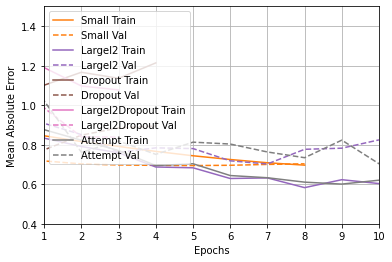

In [32]:
plotter.plot(regularizer_histories)
plt.ylim([0.4, 1.5])
plt.xlim([1, 10])
plt.legend(loc="upper left")


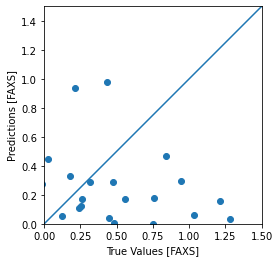

In [19]:
y_pred = attempt_l2_dropout.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [FAXS]')
plt.ylabel('Predictions [FAXS]')
lims = [0, 1.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

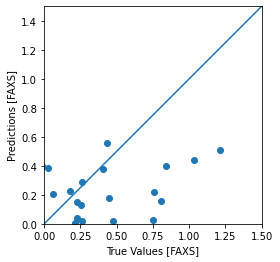

In [20]:
y_pred = small_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [FAXS]')
plt.ylabel('Predictions [FAXS]')
lims = [0, 1.5]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)